In [64]:
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score, precision_score, recall_score 
from imblearn.over_sampling import SMOTE
import joblib
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, fbeta_score

# Preprocessing

In [115]:
from zipfile import ZipFile
z = ZipFile("data/X_sample.zip")
sample = pd.read_csv(z.open('X_sample.csv'), index_col='SK_ID_CURR',encoding='utf-8')

In [7]:
y.shape

(10745, 1)

# Entraînement des modèles

In [111]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    
    plt.subplot(212)
    indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
        features.append(X.columns[indices[i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

    plt.show()

In [123]:
X_train, X_test, y_train, y_test = train_test_split(sample.drop(['TARGET'], axis=1),
                                                    sample.TARGET,
                                                    test_size=0.3,
                                                    random_state=11)

In [124]:
%%time
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

CPU times: user 284 ms, sys: 731 ms, total: 1.01 s
Wall time: 130 ms


In [125]:
def train_model(X_train, X_test, y_train, y_test, model, param_grid):
     
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    clf = model

    #pipeline = imbpipeline(steps=[['smote', SMOTE(random_state=11)], ['classifier', clf]], 'scoring'=fbeta_score(beta=0.3))

    fbeta_scorer = make_scorer(fbeta_score,beta=0.2)

    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=4,
                               n_jobs=10,
                               verbose=2,
                               scoring=fbeta_scorer)

    grid_search.fit(X_train, y_train)
    cv_score = grid_search.best_score_
    print(54 * '#')
    clf = grid_search.best_estimator_
    test_score = clf.score(X_test, y_test)

    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

    return clf

## Extratrees Classifier

In [133]:
y_train_res.value_counts()

0.0    19272
1.0    19272
Name: TARGET, dtype: int64

[CV] END ...................criterion=gini, n_estimators=100; total time=   6.7s
[CV] END ................criterion=entropy, n_estimators=100; total time=   6.9s
[CV] END ...................criterion=gini, n_estimators=100; total time=   6.8s
[CV] END ................criterion=entropy, n_estimators=100; total time=   6.9s
[CV] END ...................criterion=gini, n_estimators=300; total time=  19.2s
[CV] END ...................criterion=gini, n_estimators=300; total time=  19.3s
[CV] END ...................criterion=gini, n_estimators=300; total time=  19.2s
[CV] END ...................criterion=gini, n_estimators=300; total time=  19.4s
[CV] END ...................criterion=gini, n_estimators=100; total time=   6.9s
[CV] END ................criterion=entropy, n_estimators=300; total time=  17.1s
[CV] END ...................criterion=gini, n_estimators=100; total time=   6.8s
[CV] END ................criterion=entropy, n_estimators=300; total time=  17.2s
[CV] END ................cri

In [127]:
ETC_param_grid = {
        'n_estimators': [100, 300],
        'criterion': ['gini', 'entropy']
    }

In [146]:
etc = train_model(X_train_res, X_test, y_train_res, y_test, ExtraTreesClassifier(), ETC_param_grid)

(38544, 149) (9000, 149) (38544,) (9000,)
Fitting 4 folds for each of 4 candidates, totalling 16 fits
######################################################
Cross-validation score: 0.9852249379603122
Test score: 0.9113333333333333


In [150]:
pickle.dump(etc, open('model/ExtraTreesClassifier.pkl', 'wb'))

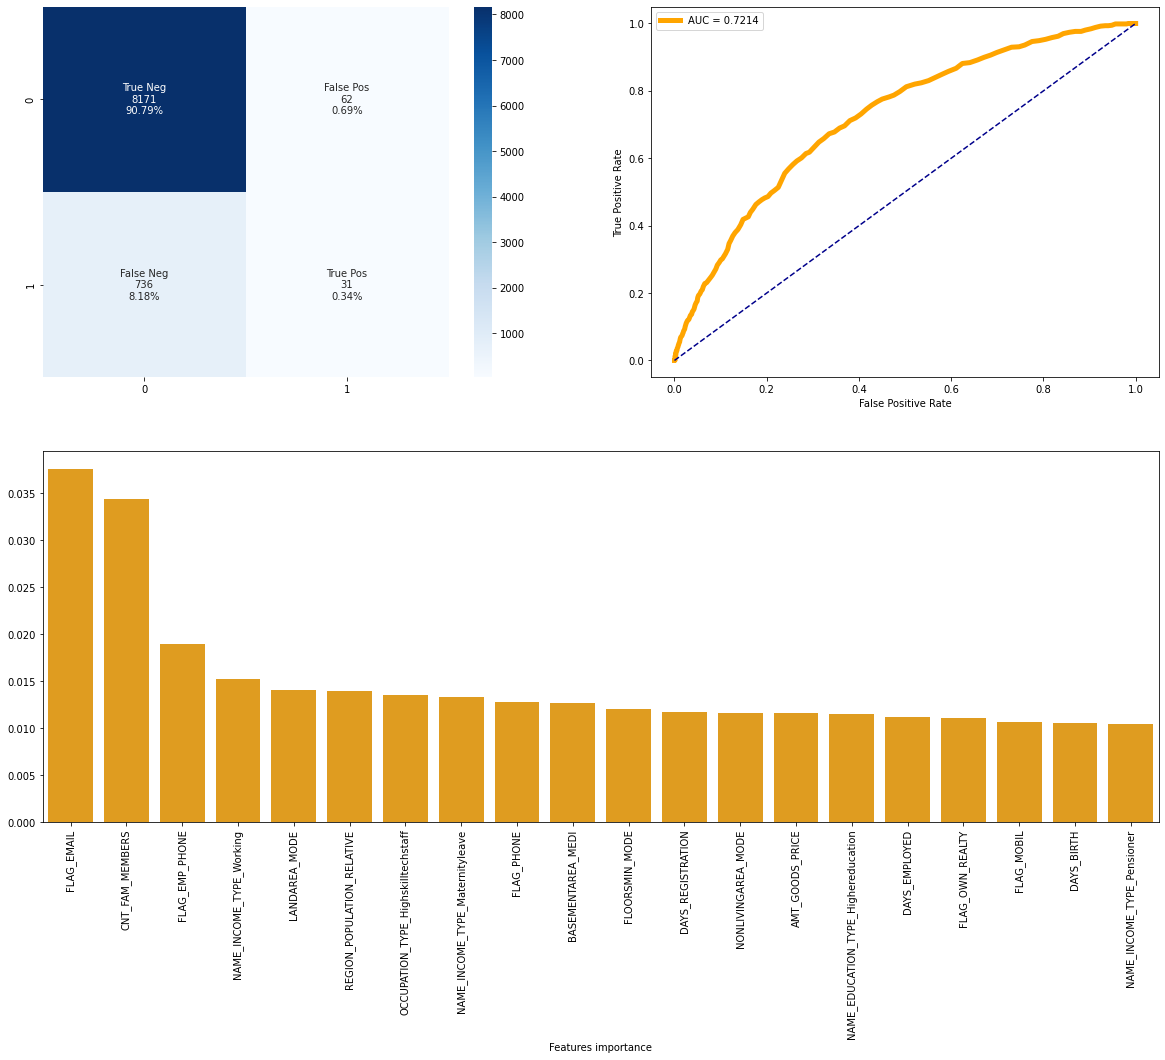

[CV] END ...................criterion=gini, n_estimators=100; total time=   6.9s
[CV] END ................criterion=entropy, n_estimators=100; total time=   7.2s
[CV] END ...................criterion=gini, n_estimators=100; total time=   6.9s
[CV] END ................criterion=entropy, n_estimators=100; total time=   7.4s
[CV] END ...................criterion=gini, n_estimators=300; total time=  19.8s
[CV] END ...................criterion=gini, n_estimators=300; total time=  20.0s
[CV] END ...................criterion=gini, n_estimators=300; total time=  20.0s
[CV] END ...................criterion=gini, n_estimators=300; total time=  20.0s
[CV] END ...................criterion=gini, n_estimators=100; total time=   7.1s
[CV] END ................criterion=entropy, n_estimators=300; total time=  17.6s
[CV] END ...................criterion=gini, n_estimators=100; total time=   7.2s
[CV] END ................criterion=entropy, n_estimators=300; total time=  17.6s
[CV] END ................cri

In [151]:
roc_auc = roc_auc_score(y_test, etc.predict_proba(X_test)[:,1])
cf_matrix_roc_auc(etc, y_test, etc.predict(X_test), etc.predict_proba(X_test)[:,1], feature_importances=False)

## XGBosst Classifier

In [134]:
XGB_param_grid = {
        'min_child_weight': [5],
        'gamma': [0.5, 1],
        'subsample': [0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3, 4]
    }

In [135]:
%%time
xgb = train_model(X_train_res, X_test, y_train_res, y_test, XGBClassifier(), XGB_param_grid)

(38544, 149) (9000, 149) (38544,) (9000,)
Fitting 4 folds for each of 8 candidates, totalling 32 fits
######################################################
Cross-validation score: 0.9814321586026776
Test score: 0.9086666666666666
CPU times: user 17.6 s, sys: 3.28 s, total: 20.9 s
Wall time: 49.4 s


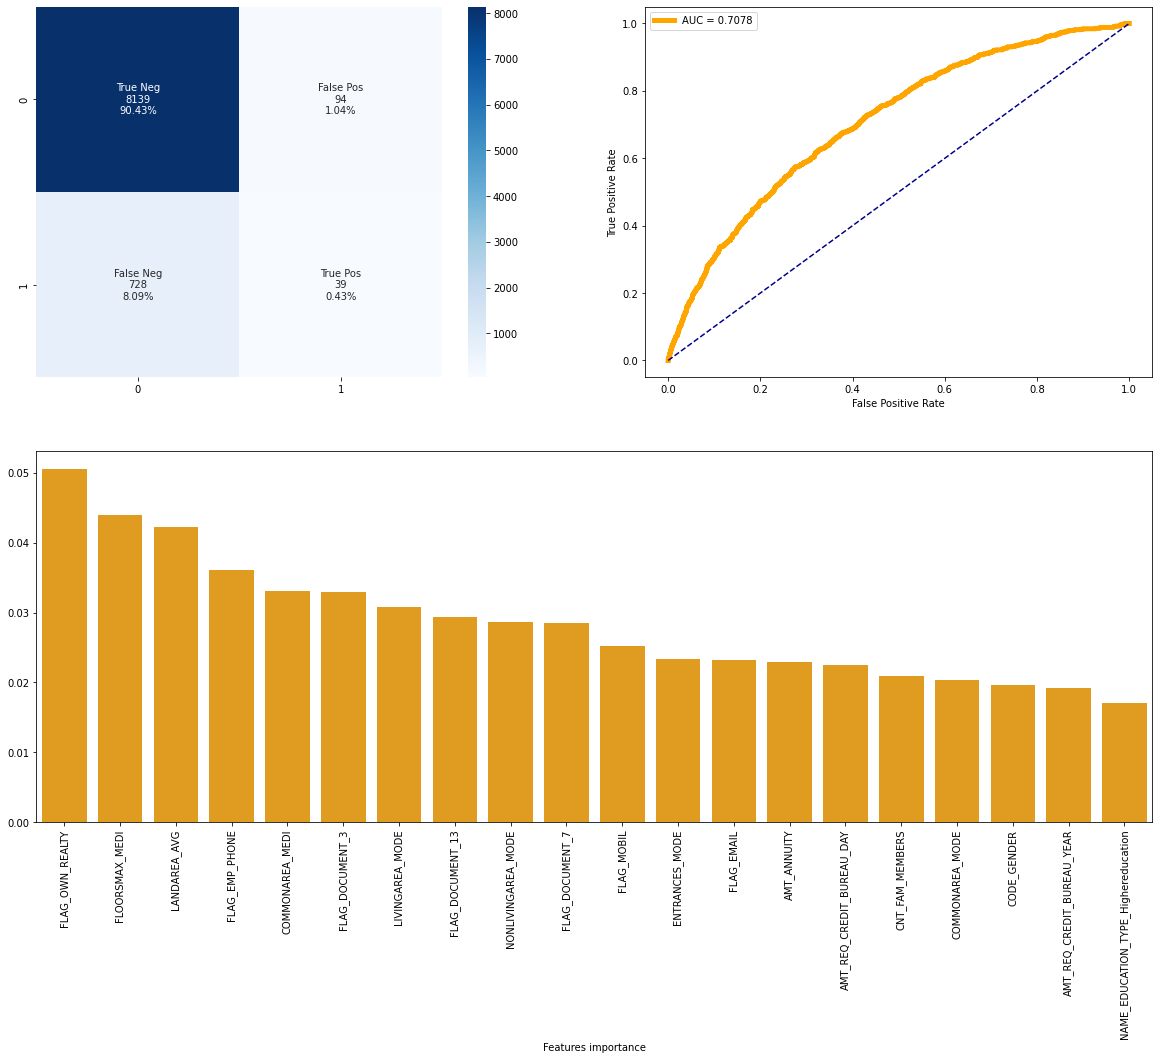

In [138]:
roc_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])
cf_matrix_roc_auc(xgb, y_test, xgb.predict(X_test), xgb.predict_proba(X_test)[:,1], feature_importances=False)
                                                     
                                                     

In [140]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [141]:
pickle.dump(xgb, open('model/XGBClassifier.pkl', 'wb'))

## LGBM Classifier

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM

In [ ]:
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
LGBM_param_grid = {
        'classifier__learning_rate': [0.01, 0.02],
        'classifier__n_estimators': [100],
        'classifier__num_leaves': [12, 16, 20],  # large num_leaves helps improve accuracy but might lead to over-fitting
        'classifier__boosting': ['gbdt'],  # for better accuracy -> try dart
        'classifier__objective': ['binary'],
        'classifier__max_bin': [100, 255],  # large max_bin helps improve accuracy but might slow down training progress
        'classifier__random_state': [500],
        'classifier__subsample': [0.7],
        'classifier__reg_alpha': [1],
        'classifier__reg_lambda': [1.4, 2.]
    }

In [ ]:
%%time
lgbm, X_train, X_test, y_train, y_test = train_model(X, y, LGBMClassifier(), XGB_param_grid)

# Résumé des scores des modèles

In [142]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):

    model.fit(X_train_selected, y_train)
    output = {
        'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
        'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
        'Precision': precision_score(y_test, model.predict(X_test_selected)),
        'Recall': recall_score(y_test, model.predict(X_test_selected)),
        'F1': f1_score(y_test, model.predict(X_test_selected)),
        'Fbeta': fbeta_score(y_test, model.predict(X_test_selected), beta=0.3)
    }
          
    return output

In [144]:
%%time
import time
name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
fbeta = []
time_ = []
models = [lgbm,
          xgb,
          etc
          ]
for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    fbeta.append(results['Fbeta'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, fbeta, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Fbeta', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 17.9 s, sys: 2.26 s, total: 20.2 s
Wall time: 10 s


In [145]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Fbeta,Time
0,XGBClassifier,0.743439,0.913444,0.421053,0.041721,0.075919,0.240502,1.304298
1,ExtraTreesClassifier,0.732141,0.914778,0.0,0.0,0.0,0.0,8.722533
